# What to do with audio if you're sick of listening

##### By: Aaron Alef (Email: aaron.alef@code.berlin - Slack: [@aaron](https://slack.com/app_redirect?team=T54B2S3T9&channel=U82F166U9))

----
**In June 2017 Mozilla launched their project ["Common Voice"](https://voice.mozilla.org/en) - an open-source project to provide audio data sets for speech recognition to everyone. As of May 2019 it contains over 1000 hours of validated speech in 20 different languages.  
So wouldn't it be cool if this could be used to support you in listening, by using it for speech recognition?  
The process of doing so is described in the 'Natural Language Processing' Folder - but in order to make use of this data it has to be processed...  
This document aims at describing this process with it's facettes and tricks. And it *is* tricky**

----

## Introduction

Voice is complex.
Regardless of whether it's a human or an animal talking, the way they exchange their distinctive sounds can become very complex.  
As I showed in the Jupyter Notebook about Natural Language Processing, the sound waves of a simple sentence being spoken looks rather like random data points than something meaningful and yet...  
Just listening back to sound tells us it's *not* random data. Thus, the next logic step is doing something with this data. And, what'd be more intuitive than trying to recognize it?  
Though in order to achieve what children fail with even after years of training, we need to ask the question, what *is* this data? How is sound stored digitally?  
And, of course, we want to look at the data set we've got - What is it, and what can we use it for?

Since this notebook is not directly about a problem, I will just visualise the data and see what we can learn from it.

## Data

Since the data sets can be quite large (up to around 20 GB) I recommend that you already start downloading it.  
I'll use examples for the english language only, but feel free to test everything in other languages as well.
Also, there are a few dependencies that need to be installed in order to run everything.

In [9]:
COMMAND = "pip install --user -r ../../requirements.txt"

from os import system
system(COMMAND)

0

You can either download it [here](https://voice.mozilla.org/en/datasets) or using the python script below:

In [1]:
from transcription import prepare

LANG='en'
prepare.Prepare(LANG, mode="download", show_progress=False)

from https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-1/en.tar.gz...


202705it [00:02, 99898.93it/s] 

Interrupted by user.


SystemExit: 1

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Sound

But let's go away from the data set for now, and focus shortly on what voice is made up and how it's stored on a computer.

Sound consists of sonic waves transmitted over a medium, mostly air. We can capture it using analog sensors, that is, a microphone.  
Since we can't store waves (as waves are expanding oscillations) we need to find a way around that - which is called sampling. We take samples every few microseconds, at a so-called sample rate given in hertz and store this in a continous stream. We can look at this stream by loading an audio file (I've taken file a from the NLP notebook).
Also, we can load a tsv file containing the audio in order to get some more information about it. I've taken the `validated.tsv` file as it contains all audio clips which we're validated by other people.

In [1]:
from transcription import visualise
from os.path import join

# TODO: Location of unzipped project:
PATH_TO_PROJECT = "../../Data/en"

FILE = "77c44851bac797d08b5724fcd0412c0a073f7888adc34a5ab588669e08319729647c4bc28e10a4b0609a7cdd15016f91e5a945314fab8392e4225df53744e51f.mp3"
TABLE = "validated.tsv"

audio = visualise.Visualise(join(PATH_TO_PROJECT, "clips", FILE), tsv=join(PATH_TO_PROJECT, TABLE))

We can now look at the sampled data, the sample rate and its metadata stored in the validated.tsv:

In [2]:
sr = audio.sample_rate

print("Sample Rate of the audio file: " + str(sr))

# Print 20 samples starting at the fifth second:
print(audio.data[(5*sr) : (5*sr + 20)])

# Show the table entry of the audio file:
audio.metadata

Sample Rate of the audio file: 22050
[-0.01885764 -0.0272058  -0.0357662  -0.04296669 -0.04838737 -0.04560987
 -0.0375044  -0.02255747 -0.00750283  0.00444547  0.01054961  0.00404552
 -0.02160558 -0.06494284 -0.11601822 -0.15945661 -0.18460864 -0.18714596
 -0.16486757 -0.11757588]


,client_id,path,sentence,up_votes,down_votes,age,gender,accent
2247,1f316ddca02594b5010fdecbe8c071bccbd29375500b13161ca26afe4737fa013101d69cb09eff35293238e7b14075018231b70abdba72fec1c3a4adbd7efaab,77c44851bac797d08b5724fcd0412c0a073f7888adc34a5ab588669e08319729647c4bc28e10a4b0609a7cdd15016f91e5a945314fab8392e4225df53744e51f,"One of the first problems you'll run into is recognition errors, particularly with any command that allows raw dictation.",2,0,NaN,NaN,NaN


Also, we might want to listen to it:

In [3]:
audio.play()

And, to come back at what I said earlier, here a look at a diagram showing sampled audio:

/usr/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


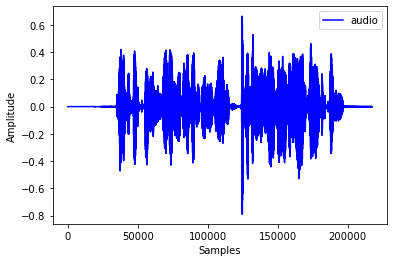

In [4]:
# Plot the samples of both audio files
import matplotlib.pyplot as plt

plt.plot(audio.data, 'b', label='audio')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()

### Data set

Let's get back to the data set.  
I've already shown one line in it without explaining, so... what does it show?

In [5]:
import pandas as pd

table = pd.read_csv(join(PATH_TO_PROJECT, TABLE), sep='\t')
table.columns.values

array(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accent'], dtype=object)

The most important thing of those for *speech recognition* is the **path**, which is our key for the audio clip, and the **sentence**, containing the actual label of the audio file.  
But there's more:
* The **client id** is a unique identification number every contributor gets. 
* The **up** and **down votes** are telling us whether the people who listened to us liked it or not.
* **Age** is a rough estimate at the age of the speaker; it's not given for everyone and not 100% accurate, but gives a nice estimate
* The **gender** is also not given for everyone, but should otherwise be self-explanatory
* The **accent** might give a clue where the person comes from - the german set, for example, provides a few clips from switzerland which are also labeled that way

If we use `pandas`'s built in `describe` function, we see numerical explanations of the numbers used in the table, which is the up and down votes:

In [6]:
table.describe()

,up_votes,down_votes
count,490483.000000,490483.000000
mean,2.653558,0.196910
std,7.408856,1.125418
min,2.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,1613.000000,528.000000


This let's us get an overview overwhat the numbers mean:

Even though we have an average of only 2.65 up votes per clip, the numbers go up to 1613.  
Luckily, for the down votes the numbers are a lot smaller, with an average of under 0.2 votes per clip.

But of course we can also look at the other fields:

In [7]:
table.count()

client_id     490483
path          490483
sentence      490480
up_votes      490483
down_votes    490483
age           249443
gender        250749
accent        215116
dtype: int64

What might look weird at the first glance is a fact I mentioned above: not every audio clip is fully labeled, and pandas automatically excludes missing entries from the count.

In [9]:
visualise.bar_graph(table.gender)

ValueError: If using all scalar values, you must pass an index

----
## Conclusion

----

## References
* https://www.talend.com/resources/what-is-data-processing/
* 